# End-to-end notebook: fisher sampling graphs


In [8]:
# install dependencies

! pip install -q joblib  # joblib for memoizing functions
! pip install -q ipywidgets widgetsnbextension pandas-profiling # IProgress for progress bars

In [9]:
# Add model_merging to the python path

import os
import sys

model_merging_base = os.path.abspath("../model_merging/")
# assert it exist
assert os.path.exists(model_merging_base)
if model_merging_base not in sys.path:
    sys.path.append(model_merging_base)

In [10]:
# import joblib for caching and distributed computing
from math import sqrt

from joblib import Memory, Parallel, delayed

# memory = Memory(location="cache", verbose=10)
memory = Memory(location="cache", verbose=0)

parallel = Parallel(n_jobs=2, return_as="generator")
output_generator = parallel(delayed(sqrt)(i**2) for i in range(10))

/Users/briancruz/2023-fall-cs-194-294-merging-llms/.venv/lib/python3.8/site-packages/joblib/parallel.py:1762: UserWarning: 10 tasks have been successfully executed  but not used. Additionally, 0 tasks which were still being processed by the workers have been cancelled. You could benefit from adjusting the input task iterator to limit unnecessary computation time.
  warnings.warn(msg)


In [11]:
# Imports and cached functions

import os

from llm_weaver import (
    calculate_score_from_weaving_config,
    get_score_from_named_model,
    test_weaver,
)

# Disable parallelism in tokenizers to avoid deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

calculate_score_from_weaving_config_cached = memory.cache(
    calculate_score_from_weaving_config
)
test_weaver_cached = memory.cache(test_weaver)

get_score_from_named_model_cached = memory.cache(get_score_from_named_model)

## Define weave config generator


In [12]:
import numpy as np
from llm_weaver import dict_overwrite, get_model_config

from model_merging import hdf5_util, sample_layers


def sample_weave_configs_fisher_sampling_iter(
    alpha_blend,
    beta_choice,
    loc_spread,
    output_length,
    models,
    blank_model_template_model_id,
    max_configs=1,
):
    fishers = [
        hdf5_util.load_variables_from_hdf5(fisherpath, trainable=False)
        for fisherpath in [model["fishers_path"] for model in models]
    ]
    blank_model_config = dict_overwrite(
        get_model_config(blank_model_template_model_id),
        {
            "num_hidden_layers": output_length,
        },
    )
    # Bring the random seed outside the loop for reproducibility
    rng = np.random.default_rng(seed=42)
    for _ in range(max_configs):
        layer_config = list(
            sample_layers.generate_layer_config(
                fishers,
                dict(
                    alpha_blend=alpha_blend,
                    beta_choice=beta_choice,
                    loc_spread=loc_spread,
                    output_length=output_length,
                ),
                minus_one=False,
                rng=rng,
            )["layers"]
        )
        # print(layer_config)

        config = {
            "glue_task": "rte",
            "tokenizer_model_id": blank_model_template_model_id,
            # The task (i.e. the classification head output size should match the task at hand)
            "blank_model_config": blank_model_config,
            # Layer assignments
            "layer_assignments": [
                {
                    "type": "SingleLayer",
                    "params": {
                        "donor": models[int(model_n_layer_m.split("_")[1])][
                            "model_id"
                        ],  # the n in model_n_layer_m
                        # Pick a layer
                        "hidden_layer_number": int(
                            model_n_layer_m.split("_")[-1]
                        ),  # the m in model_n_layer_m
                    },
                }
                for model_n_layer_m in layer_config
            ],
            # The head (i.e. the classification head should match the task at hand)
            # THESE ARE DIFFERENT BETWEEN RTE AND MNLI
            "classification_head": {
                "type": "SingleClassificationHead",
                "params": {
                    "donor": blank_model_template_model_id,
                },
            },
            # The embeddings layer
            # THESE ARE DIFFERENT BETWEEN RTE AND MNLI
            "embeddings": {
                "type": "SingleEmbeddings",
                "params": {
                    "donor": blank_model_template_model_id,
                },
            },
        }
        yield config
        # yield generate_layer_config(fishers, sample_config)
    # # Need to decide what to do about embeddings and classification head.


# sample_layers.generate_fisher_distributions(fishers)


list(
    sample_weave_configs_fisher_sampling_iter(
        **{
            "alpha_blend": 1,  # fisher weight vs location weight
            "beta_choice": 1,  # which model to choose from
            "loc_spread": 0.01,  # spread of location weight
            "output_length": 24,
            "models": [
                {
                    "model_id": "textattack/roberta-base-RTE",
                    "fishers_path": "../data/fisher_info/rte_fisher.h5",
                },
                {
                    "model_id": "textattack/roberta-base-MNLI",
                    "fishers_path": "../data/fisher_info/mnli_fisher.h5",
                },
            ],
            "blank_model_template_model_id": "textattack/roberta-base-RTE",
        },
        max_configs=1,
    )
)

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model 0 has 12 layers.
Model 1 has 12 layers.


[{'glue_task': 'rte',
  'tokenizer_model_id': 'textattack/roberta-base-RTE',
  'blank_model_config': {'return_dict': True,
   'output_hidden_states': False,
   'output_attentions': False,
   'torchscript': False,
   'torch_dtype': None,
   'use_bfloat16': False,
   'tf_legacy_loss': False,
   'pruned_heads': {},
   'tie_word_embeddings': True,
   'is_encoder_decoder': False,
   'is_decoder': False,
   'cross_attention_hidden_size': None,
   'add_cross_attention': False,
   'tie_encoder_decoder': False,
   'max_length': 20,
   'min_length': 0,
   'do_sample': False,
   'early_stopping': False,
   'num_beams': 1,
   'num_beam_groups': 1,
   'diversity_penalty': 0.0,
   'temperature': 1.0,
   'top_k': 50,
   'top_p': 1.0,
   'typical_p': 1.0,
   'repetition_penalty': 1.0,
   'length_penalty': 1.0,
   'no_repeat_ngram_size': 0,
   'encoder_no_repeat_ngram_size': 0,
   'bad_words_ids': None,
   'num_return_sequences': 1,
   'chunk_size_feed_forward': 0,
   'output_scores': False,
   'return

## Graph single run which should be identical to textAttack/roberta-base-RTE

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.


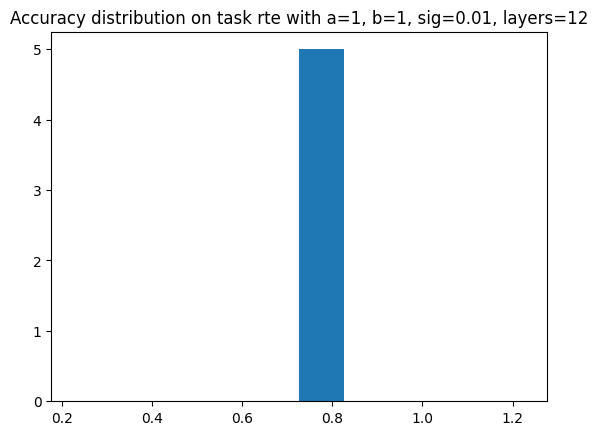

In [13]:
import matplotlib.pyplot as plt


def sample_config_to_plots(sample_config, n_examples=128, split="validation", n_jobs=5):
    weave_configs = list(
        sample_weave_configs_fisher_sampling_iter(**sample_config),
    )

    scores = Parallel(n_jobs=n_jobs, return_as="list")(
        delayed(calculate_score_from_weaving_config_cached)(
            weave_config,
            n_examples=n_examples,
            split=split,
        )
        for weave_config in weave_configs
    )
    accuracies = [score["accuracy"] for score in scores]

    title = f"Accuracy distribution on task {weave_configs[0]['glue_task']} with a={sample_config['alpha_blend']}, b={sample_config['beta_choice']}, sig={sample_config['loc_spread']}, layers={sample_config['output_length']}"

    # create figure and ax
    fig, ax = plt.subplots()
    ax.hist(accuracies, bins=10)
    ax.set_title(title)
    plt.show()

    return accuracies, weave_configs


accuracies, weave_configs = sample_config_to_plots(
    {
        "alpha_blend": 1,  # fisher weight vs location weight
        "beta_choice": 1,  # which model to choose from
        "loc_spread": 0.01,  # spread of location weight
        "output_length": 12,
        "models": [
            {
                "model_id": "textattack/roberta-base-RTE",
                "fishers_path": "../data/fisher_info/rte_fisher.h5",
            },
            {
                "model_id": "textattack/roberta-base-MNLI",
                "fishers_path": "../data/fisher_info/mnli_fisher.h5",
            },
        ],
        "blank_model_template_model_id": "textattack/roberta-base-RTE",
        "max_configs": 5,
    },
)

## Graph many examples

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.


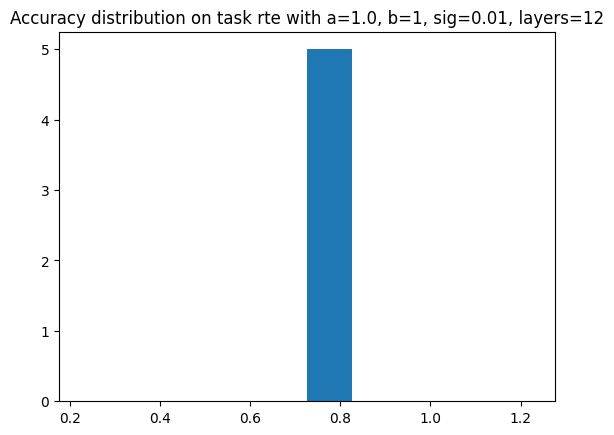

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.


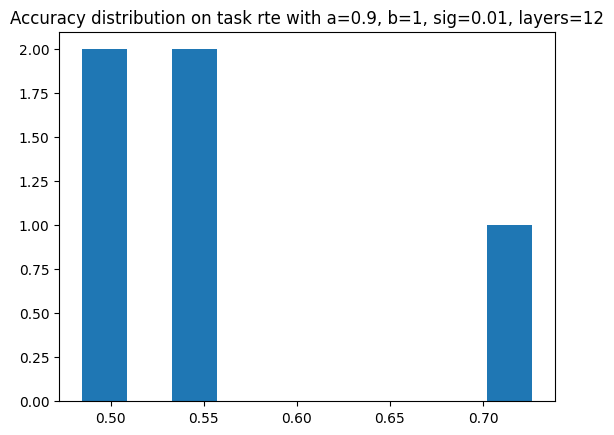

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.


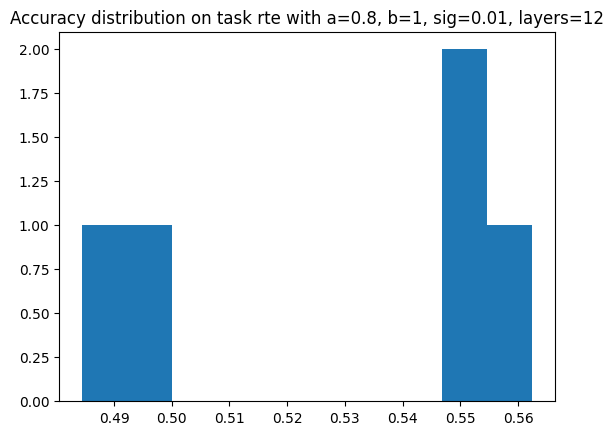

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.


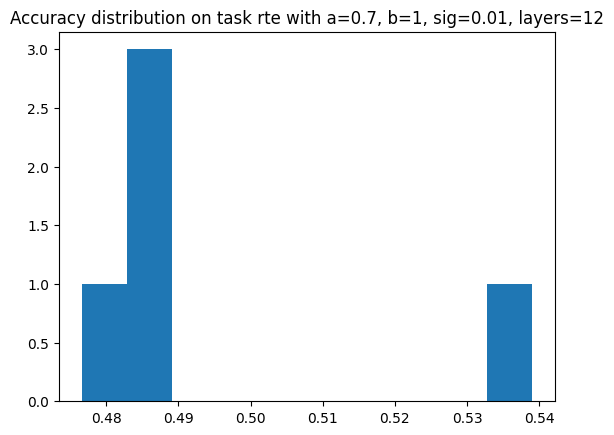

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.


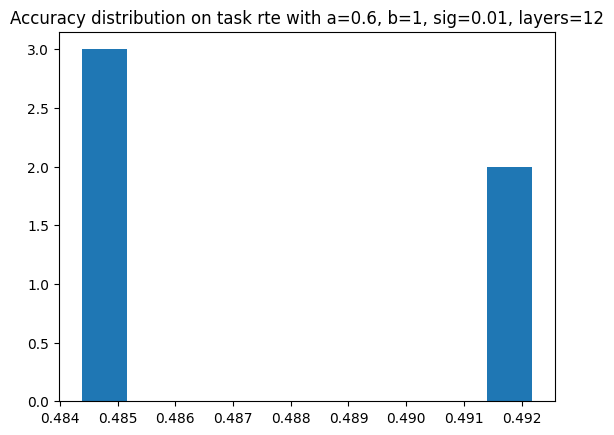

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.
Model 0 has 12 layers.
Model 1 has 12 layers.


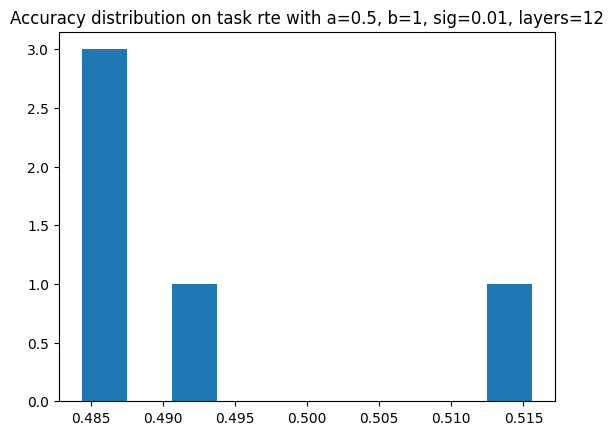

In [14]:
for alpha in [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]:
    # from all locations to part fisher
    accuracies, weave_configs = sample_config_to_plots(
        {
            "alpha_blend": alpha,  # fisher weight vs location weight
            "beta_choice": 1,  # which model to choose from
            "loc_spread": 0.01,  # spread of location weight
            "output_length": 12,
            "models": [
                {
                    "model_id": "textattack/roberta-base-RTE",
                    "fishers_path": "../data/fisher_info/rte_fisher.h5",
                },
                {
                    "model_id": "textattack/roberta-base-MNLI",
                    "fishers_path": "../data/fisher_info/mnli_fisher.h5",
                },
            ],
            "blank_model_template_model_id": "textattack/roberta-base-RTE",
            "max_configs": 5,
        },
        n_jobs=3,  # Reduce this if your computer is slowing down too much
    )

In [15]:
# Inspect the weave configs to make sure they are reasonable
weave_configs

[{'glue_task': 'rte',
  'tokenizer_model_id': 'textattack/roberta-base-RTE',
  'blank_model_config': {'return_dict': True,
   'output_hidden_states': False,
   'output_attentions': False,
   'torchscript': False,
   'torch_dtype': None,
   'use_bfloat16': False,
   'tf_legacy_loss': False,
   'pruned_heads': {},
   'tie_word_embeddings': True,
   'is_encoder_decoder': False,
   'is_decoder': False,
   'cross_attention_hidden_size': None,
   'add_cross_attention': False,
   'tie_encoder_decoder': False,
   'max_length': 20,
   'min_length': 0,
   'do_sample': False,
   'early_stopping': False,
   'num_beams': 1,
   'num_beam_groups': 1,
   'diversity_penalty': 0.0,
   'temperature': 1.0,
   'top_k': 50,
   'top_p': 1.0,
   'typical_p': 1.0,
   'repetition_penalty': 1.0,
   'length_penalty': 1.0,
   'no_repeat_ngram_size': 0,
   'encoder_no_repeat_ngram_size': 0,
   'bad_words_ids': None,
   'num_return_sequences': 1,
   'chunk_size_feed_forward': 0,
   'output_scores': False,
   'return